# Setup

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [2]:
def plot_fn(f, *params):
    plt.scatter(X, Y)
    x = np.linspace(min(X), max(X), 100)
    y = [f(*params, x_) for x_ in x]
    plt.plot(x, y, 'r')

In [3]:
data = [
    (-0.8, 30.5), (3.8, 40.6), (7.6, 51.2), (10.8, 49.9), (15.8, 63.4),
    (15.9, 57.8), (20.4, 80.6), (24.1, 73.9), (25.5, 72.5), (32.5, 86.8),
    (35.0, 100.1), (36.6, 93.2), (40.2, 101.3), (44.1, 109.4), (48.0, 117.3),
    (52.7, 128.2), (55.0, 137.0), (58.6, 140.8), (61.2, 140.8), (66.5, 155.6),
    (68.2, 156.3), (71.3, 159.7), (76.6, 169.6), (79.0, 174.0), (84.5, 176.4),
    (83.7, 183.4), (90.5, 200.1), (92.9, 199.2), (97.6, 200.3), (100.3, 217.9)]

X, Y = list(zip(*data))
X = np.array(X)
Y = np.array(Y)

# Exploration

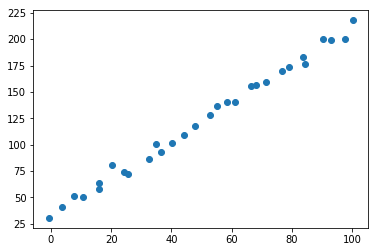

In [4]:
plt.scatter(X, Y)

# Defining the search space and the loss

Let's assume that there's a linear relationship between $x$ and $y$. Below, $a$ and $b$ are parameters.

In [5]:
def f(a, b, x):
    return a*x+b

Let's use mean squared error loss:

$$ l(a, b) = \frac{1}{n} \sum_{i = 1}^{n} \left( f(a, b, X_i) - Y_i \right)^2 $$

In [6]:
def loss(a, b):
    return 1/len(X) * np.sum((f(a, b, X) - Y)**2)

In [7]:
loss(1, 2)

5517.001

In [8]:
loss(2, 10)

211.6146666666666

Let's visualize what the loss surface looks like.

Eventually, we'll want to find an $a$ and $b$ that minimize the loss.

In [9]:
num_samples = 300
a_space = np.linspace(1, 3, num_samples)
b_space = np.linspace(-30, 100, num_samples)
losses = np.zeros((num_samples, num_samples))
for i in range(len(a_space)):
    for j in range(len(b_space)):
        losses[j, i] = loss(a_space[i], b_space[j])
losses = np.log(losses)

Let's visualize log-loss since it looks nicer.

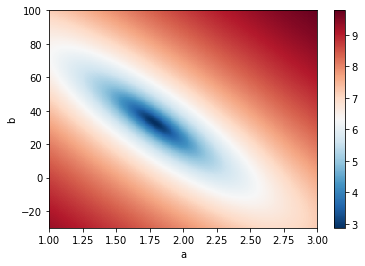

In [10]:
p = plt.pcolor(a_space, b_space, losses, cmap=cm.RdBu_r, vmin=losses.min(), vmax=losses.max())
plt.xlabel('a')
plt.ylabel('b')
plt.colorbar(p)

# Backpropagation

We need $\frac{\partial l}{\partial a}$ and $\frac{\partial l}{\partial b}$ in order to do gradient descent on our parameters. First, let's compute those via the chain rule (01-06-notes).

In [11]:
def partial_a(a, b):
    return np.sum(X*2*(a*X+b-Y) / len(X))

In [12]:
def partial_b(a, b):
    return np.sum(2*(a*X+b-Y) / len(X))

In [13]:
%timeit partial_a(1, 2), partial_b(1, 2)

17.4 µs ± 702 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Now, let's use backpropagation (dynamic programming) to speed this up (01-06-notes). Also, take note of the forward pass (computing outputs of the operations in the graph) and backward pass (computing derivatives of the operations in the graph).

The absolute speedup here is small because this computation is so fast, but when you have large and deep neural networks, and you're differentiating with respect to millions of parameters, this speedup is huge.

In [14]:
# returns a tuple (dl/da, dl/db)
def compute_grad(a, b):
    dl_dy = 2*(a*X+b-Y) / len(X)
    dl_db = np.sum(dl_dy)
    dl_da = np.sum(X * dl_dy)
    return dl_da, dl_db

In [15]:
%timeit compute_grad(1, 2)

11.1 µs ± 71.1 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


Even in this simple example, we see a speedup. The naive version is about 50% slower than the version using backpropagation.

# Gradient descent

In [16]:
a_init = 2.0 # a reasonable initial guess
b_init = 3.0
alpha = 1e-4 # learning rate

a = a_init
b = b_init

losses = []
for iteration in range(100000):
    # compute loss (for visualization)
    losses.append(loss(a, b))
    
    # compute gradients
    dl_da, dl_db = compute_grad(a, b)
    # update parameters
    a = a - alpha * dl_da
    b = b - alpha * dl_db

print('final loss=%f' % loss(a, b))

final loss=17.723258


Let's visualize how our loss changed over the iterations.

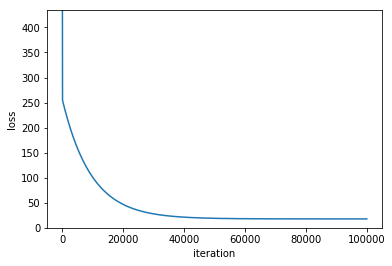

In [17]:
plt.plot(losses)
plt.ylim(0, np.max(losses))
plt.ylabel('loss')
plt.xlabel('iteration')
_

Let's visualize our learned function, along with our data points.

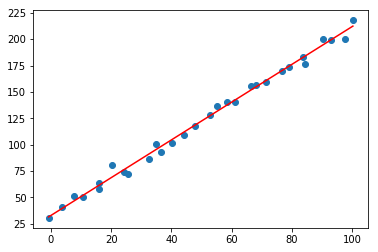

In [18]:
plot_fn(f, a, b)

What is our learned $f$?

In [19]:
print('f(x) = %.1fx + %.1f' % (a, b))

f(x) = 1.8x + 32.9


# Automatic differentiation

What we've been doing has been pretty mechanical, and it can be automated. TensorFlow is a library for writing computation graphs and automatically differentiating through them.

## Setup

In [20]:
import tensorflow as tf
sess = tf.InteractiveSession()

## Defining parameters

$$\theta = \begin{bmatrix}
a \\
b
\end{bmatrix}$$

In [21]:
theta = tf.Variable([a_init, b_init])
sess.run(tf.global_variables_initializer())

# Defining the function (search space) and the loss

In [22]:
x = tf.placeholder(tf.float32, [None])
y = tf.placeholder(tf.float32, [None])

In [23]:
f_tf = theta[0] * x + theta[1]

In [24]:
loss_tf = tf.reduce_sum((f_tf - y)**2) / len(X)

In [25]:
loss(a_init, b_init) # numpy version

434.02799999999996

In [26]:
loss_tf.eval({x: X, y: Y}) # from tensorflow

434.028

## Automatically compute the gradient!

TensorFlow supports automatic differentiation, so this is all we need to do in order to compute the gradient:

In [27]:
d_theta, = tf.gradients(loss_tf, theta)

## Update step

In [28]:
next_theta = theta - alpha * d_theta

## Gradient descent

We're actually not going to use our `d_theta` or `next_theta`. We're going to use one of TensorFlow's built-in optimizers, which will even take the step of calling `tf.gradients` for us.

Let's use a fancier variation of gradient descent to optimize this: [Adam](https://arxiv.org/abs/1412.6980) (Kingma & Ba 2014). We can instantiate TensorFlow's Adam optimizer and tell it what quantity we want to minimize. It'll figure out the rest (including automatically computing the gradient).

In [29]:
optim = tf.train.AdamOptimizer(learning_rate=1e-2).minimize(loss_tf)

## Gradient descent

In [30]:
losses = []
sess.run(tf.global_variables_initializer()) # initialize theta (and also Adam internal state variables)
for i in range(5000):
    l, _ = sess.run([loss_tf, optim], {x: X, y: Y})
    losses.append(l)
    
print('final loss=%f' % loss_tf.eval({x: X, y: Y}))

final loss=17.867399


Visualizing the loss curve.

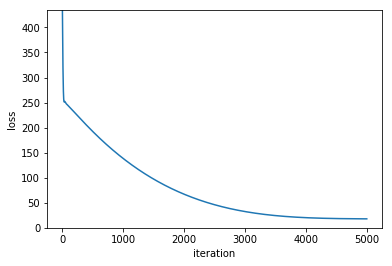

In [31]:
plt.plot(losses)
plt.ylim(0, np.max(losses))
plt.ylabel('loss')
plt.xlabel('iteration')
_

Let's look at the learned parameter.

In [32]:
theta.eval()

array([ 1.7983513, 32.257317 ], dtype=float32)

And the learned function.

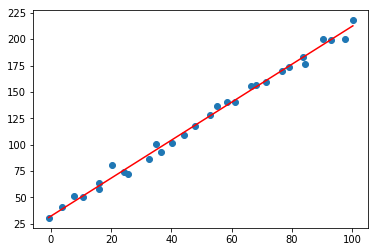

In [33]:
plot_fn(f, *theta.eval())

# Minimizing something else

We can use gradient descent to minimize any quantity. For example, if we define loss as $|f(x) - x|^2$, we can optimize over values of $x$ to find the fixed point of the function (the point where $f(x) = x$).

In [34]:
# instead of using the line of best fit, which is not exactly correct due to noise in the data,
# let's reset this back to the Celsius to Fahrenheit function
sess.run(theta.assign([1.8, 32]))
_

In [35]:
loss_fp = tf.square(f_tf - x)
g_loss_fp, = tf.gradients(loss_fp, x)

In [36]:
alpha = 1

fixed_point = np.random.normal(size=(1,)) # initial guess

for i in range(10):
    g, l = sess.run([g_loss_fp, loss_fp], {x: fixed_point})
    fixed_point = fixed_point - alpha * g_loss_fp.eval({x: fixed_point})

print('fixed point: f(%.1f) = %.1f' % (fixed_point, f_tf.eval({x: fixed_point})))

fixed point: f(-40.0) = -40.0
